4. Model

In [79]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier  # Decision Tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


In [3]:
transactions = pd.read_csv(r'C:\Users\navee\CapitalOne_Coding\clean_data.csv')

In [4]:
transactions.shape

(720701, 16)

In [5]:
transactions.head(3)

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp,creditLimit,availableMoney,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,100088067,1st BBQ,200.12,PURCHASE,T541917,2016-04-08 19:56:36,50000.0,49953.81,US,9.0,1.0,food,46.19,1,0,0
1,100088067,1st Pub,95.11,PURCHASE,T541962,2016-11-09 07:26:06,50000.0,49929.31,US,2.0,1.0,food,70.69,1,0,0
2,100088067,1st Sandwitch Bar #758805,5.26,PURCHASE,T541920,2016-05-06 02:54:01,50000.0,49996.04,US,2.0,1.0,food,3.96,1,0,0


In [7]:

# Load the dataset
df = transactions.copy()

#Standardize transactionAmount for each customer
def z_score(df):
    df_std = df.copy()
    key = df_std['transactionKey']
    df_std = df_std.drop(['transactionKey'], axis=1)
    if len(df_std) >= 2:
        for column in df_std.columns:
            df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        df_std = pd.concat([df_std, key], axis=1)
    else:
        df_std = pd.concat([df_std, key], axis=1)
        df_std['transactionAmount'] = 0
    return df_std

# Apply standardization for each customer
df_standardized = {}
for customer_id in df.customerId.unique():
    sample = df[df.customerId == customer_id][['transactionAmount', 'transactionKey']]
    df_standardized[customer_id] = z_score(sample)

# Combine all standardized data
df_combined = pd.concat(df_standardized.values(), ignore_index=True)
df_combined.rename(columns={'transactionAmount': 'Amount_Std'}, inplace=True)

#Merge standardized transaction amount with the original dataset
df = df.merge(df_combined[['transactionKey', 'Amount_Std']], how='inner', on='transactionKey')

# Categorize merchantCategoryCode
def categ_merchant(x):
    if x in ['cable/phone', 'food_delivery', 'fuel', 'gym', 'mobileapps', 'online_subscriptions']:
        return 0
    elif x in ['online_gifts', 'online_retail', 'rideshare', 'airline']:
        return 2
    elif x in ['entertainment', 'auto', 'food', 'furniture']:
        return 1
    elif x in ['personal care', 'health', 'hotels', 'subscriptions', 'fastfood']:
        return 0

df['Categ_merchant'] = df['merchantCategoryCode'].apply(categ_merchant)

# One-hot encode cardPresent (since it may not have two categories in all datasets)
df['cardPresent'] = df['cardPresent'].astype(int)  # Ensure it's binary (0 or 1)

#  One-hot encode creditLimit
df = pd.concat([df, pd.get_dummies(df['creditLimit'], prefix='CredLimit_')], axis=1)

# Categorize posEntryMode
def categ_pos(x):
    if x == 5:
        return 0
    elif x in [2, 80, 90]:
        return 1
    elif x == 9:
        return 2

df['Categ_posEntry'] = df['posEntryMode'].apply(categ_pos)

#  Categorize posConditionCode
def categ_posCon(x):
    if x == 8:
        return 0
    elif x == 1:
        return 1
    elif x == 99:
        return 2

df['Categ_posCon'] = df['posConditionCode'].apply(categ_posCon)

# Create a binary feature for transactionAmount > 250
df['Categ_Transac'] = df['transactionAmount'].apply(lambda x: 1 if x > 250 else 0)

# Select relevant columns for modeling
df_processed = df[['Amount_Std', 'Categ_Transac', 'Categ_merchant', 'cardPresent',
                   'Categ_posEntry', 'Categ_posCon', 'isFraud']]

# Fill missing values if any
df_processed.fillna(0, inplace=True)

# Final dataset ready for model
print(df_processed.head())


   Amount_Std  Categ_Transac  Categ_merchant  cardPresent  Categ_posEntry  \
0    0.806091              0               1            1               2   
1   -0.085420              0               1            1               1   
2   -0.848227              0               1            1               1   
3    0.309270              0               1            1               2   
4    1.689283              1               1            1               1   

   Categ_posCon  isFraud  
0             1        0  
1             1        0  
2             1        0  
3             0        0  
4             1        0  


C:\Users\navee\AppData\Local\Temp\ipykernel_2188\765088103.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed.fillna(0, inplace=True)


In [8]:

# Replace infinite values with NaN
df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for any remaining NaN values and handle them (you can fill with 0 or median)
df_processed.fillna(df_processed.median(), inplace=True)

# Check if the data contains any remaining NaN values after imputation
print(df_processed.isna().sum())


Amount_Std        0
Categ_Transac     0
Categ_merchant    0
cardPresent       0
Categ_posEntry    0
Categ_posCon      0
isFraud           0
dtype: int64


C:\Users\navee\AppData\Local\Temp\ipykernel_2188\2875088155.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\navee\AppData\Local\Temp\ipykernel_2188\2875088155.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed.fillna(df_processed.median(), inplace=True)


In [14]:

#  Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Initialize the Logistic Regression model with balanced class weight
log_reg_model = LogisticRegression(class_weight='balanced', 
                                   max_iter=1000,  # Increase iterations to ensure convergence
                                   random_state=42)

# Fit the model on training data
log_reg_model.fit(X_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg_model.predict(X_test)

# Evaluate the model
print("Classification Report for Logistic Regression with Class Weight Balanced:")
print(classification_report(y_test, y_pred_log_reg))

print("Confusion Matrix for Logistic Regression with Class Weight Balanced:")
print(confusion_matrix(y_test, y_pred_log_reg))


Classification Report for Logistic Regression with Class Weight Balanced:
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    212752
           1       0.03      0.67      0.06      3459

    accuracy                           0.67    216211
   macro avg       0.51      0.67      0.43    216211
weighted avg       0.98      0.67      0.79    216211

Confusion Matrix for Logistic Regression with Class Weight Balanced:
[[141834  70918]
 [  1126   2333]]


1) The Logistic Regression model identifies many fraud cases but mistakenly flags too many non-fraud transactions as fraud, making it less reliable for detecting fraud accurately.

2) Due to the imbalance between fraud and non-fraud cases, the model's performance is not ideal, so we're exploring more advanced models like Decision Trees to improve accuracy.

In [15]:

# Initialize the Decision Tree model with balanced class weight
decision_tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the model on training data
decision_tree_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = decision_tree_model.predict(X_test)

# Evaluate the model
print("Classification Report for Decision Tree with Class Weight Balanced:")
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix for Decision Tree with Class Weight Balanced:")
print(confusion_matrix(y_test, y_pred_dt))


Classification Report for Decision Tree with Class Weight Balanced:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    212752
           1       0.03      0.03      0.03      3459

    accuracy                           0.97    216211
   macro avg       0.51      0.51      0.51    216211
weighted avg       0.97      0.97      0.97    216211

Confusion Matrix for Decision Tree with Class Weight Balanced:
[[209427   3325]
 [  3342    117]]


While a Decision Tree model was tested with class weight balancing to address fraud detection, the results showed poor precision and recall for fraud cases. Specifically, the model struggled to detect fraudulent transactions effectively, capturing only 3% of fraud cases. Given these limitations, we have shifted focus to Random Forest, which has shown better potential in handling class imbalance and detecting fraud with higher accuracy.

In [9]:

# Split the dataset into features (X) and target (y)
X = df_processed.drop('isFraud', axis=1)
y = df_processed['isFraud']

#  Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#  Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    212752
           1       0.03      0.03      0.03      3459

    accuracy                           0.97    216211
   macro avg       0.51      0.51      0.51    216211
weighted avg       0.97      0.97      0.97    216211

Confusion Matrix:
 [[209377   3375]
 [  3347    112]]


Evaluation of the Random Forest model showed strong accuracy for non-fraudulent transactions, but precision and recall for the minority fraud class were limited. Class imbalance was a significant challenge, leading to the model being biased toward the majority class. To mitigate this, we applied techniques such as SMOTE, which helped improve fraud detection rates by creating a more balanced dataset.

In [10]:

# Assuming df_processed is the preprocessed data
X = df_processed.drop(['isFraud'], axis=1)
y = df_processed['isFraud']

# Step 1: Split the dataset into training and test sets (before applying SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Step 3: Train the Random Forest model on the SMOTE-balanced data
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')  # Optional: use 'balanced' for class weight
rf_model.fit(X_train_smote, y_train_smote)

# Step 4: Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Step 5: Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.68      0.80    212752
           1       0.02      0.47      0.04      3459

    accuracy                           0.67    216211
   macro avg       0.51      0.57      0.42    216211
weighted avg       0.97      0.67      0.79    216211

Confusion Matrix:
[[143641  69111]
 [  1818   1641]]


The initial results with SMOTE showed poor precision and recall, especially for the fraud class, prompting a shift to Random Forest with hyperparameter tuning to improve performance.

In [11]:
# Initialize the Random Forest model with manually tuned hyperparameters
rf_model = RandomForestClassifier(n_estimators=150,  # Increased number of trees
                                  max_depth=20,  # Depth limitation
                                  min_samples_split=10,  # Default reasonable values
                                  min_samples_leaf=2,  # Slightly higher leaf count to avoid overfitting
                                  random_state=42,
                                  n_jobs=-1)  # Use all cores

# Fit the model on training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the performance of Random Forest
print("Classification Report for Manually Tuned Random Forest:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix for Manually Tuned Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))


Classification Report for Manually Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    212752
           1       0.05      0.00      0.00      3459

    accuracy                           0.98    216211
   macro avg       0.52      0.50      0.50    216211
weighted avg       0.97      0.98      0.98    216211

Confusion Matrix for Manually Tuned Random Forest:
[[212732     20]
 [  3458      1]]


In [12]:
# Initialize the Random Forest model with class weight adjustment
rf_model = RandomForestClassifier(n_estimators=150, 
                                  max_depth=20, 
                                  min_samples_split=10, 
                                  min_samples_leaf=2, 
                                  class_weight={0: 1, 1: 10},  # Adjusted class weights
                                  random_state=42)

# Fit the model on training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report for Weighted Random Forest:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix for Weighted Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))


Classification Report for Weighted Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    212752
           1       0.06      0.02      0.03      3459

    accuracy                           0.98    216211
   macro avg       0.52      0.51      0.51    216211
weighted avg       0.97      0.98      0.97    216211

Confusion Matrix for Weighted Random Forest:
[[211637   1115]
 [  3389     70]]


In [13]:

# Initialize the Random Forest model with balanced class weight
rf_model = RandomForestClassifier(n_estimators=100, 
                                  max_depth=20, 
                                  min_samples_split=10, 
                                  min_samples_leaf=2, 
                                  class_weight='balanced',  # Automatically adjusts class weights
                                  random_state=42)

# Fit the model on training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report for Random Forest with Class Weight Balanced:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix for Random Forest with Class Weight Balanced:")
print(confusion_matrix(y_test, y_pred_rf))



Classification Report for Random Forest with Class Weight Balanced:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    212752
           1       0.05      0.32      0.08      3459

    accuracy                           0.89    216211
   macro avg       0.52      0.61      0.51    216211
weighted avg       0.97      0.89      0.93    216211

Confusion Matrix for Random Forest with Class Weight Balanced:
[[190368  22384]
 [  2359   1100]]


Despite using Random Forest with class weight adjustment, the model failed to significantly improve precision and recall for the fraud class. Based on these results, the next step is to explore XGBoost to handle the imbalanced data more effectively.

In [16]:
# Initialize the XGBoost model with class imbalance handling
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Balances the class imbalance
    random_state=42,
    use_label_encoder=False,  # Avoid warning for label encoding
    eval_metric="logloss"  # Set evaluation metric for XGBoost
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("Classification Report for XGBoost with Class Weight Balanced:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix for XGBoost with Class Weight Balanced:")
print(confusion_matrix(y_test, y_pred_xgb))


C:\Users\navee\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:15:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost with Class Weight Balanced:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    212752
           1       0.03      0.62      0.06      3459

    accuracy                           0.71    216211
   macro avg       0.51      0.66      0.45    216211
weighted avg       0.98      0.71      0.82    216211

Confusion Matrix for XGBoost with Class Weight Balanced:
[[151039  61713]
 [  1319   2140]]


In [17]:

categorical_cols = ['merchantName', 'transactionType', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode']
numerical_cols = ['transactionAmount', 'creditLimit', 'availableMoney', 'currentBalance']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])

X = df.drop(['isFraud', 'customerId', 'transactionKey', 'Timestamp'], axis=1)  # Drop non-feature columns
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Adjust ratio as needed
smote = SMOTE(random_state=42)

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

pipeline = make_pipeline(preprocessor, under_sampler, smote, rf_model)

pipeline.fit(X_train, y_train)

y_pred_rf = pipeline.predict(X_test)

print("Classification Report for Random Forest with SMOTE and Under-Sampling:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest with SMOTE and Under-Sampling:")
print(cm_rf)


Classification Report for Random Forest with SMOTE and Under-Sampling:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92    212752
           1       0.05      0.45      0.09      3459

    accuracy                           0.86    216211
   macro avg       0.52      0.65      0.51    216211
weighted avg       0.97      0.86      0.91    216211

Confusion Matrix for Random Forest with SMOTE and Under-Sampling:
[[183570  29182]
 [  1916   1543]]


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import ADASYN

# Step 1: Split the dataset into features (X) and target (y)
X = df_processed.drop('isFraud', axis=1)
y = df_processed['isFraud']

# Step 2: Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 3: Apply ADASYN for over-sampling the minority class
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Step 4: Train a Random Forest model on the ADASYN-balanced training data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_adasyn, y_train_adasyn)

# Step 5: Make predictions on the test set
y_pred_adasyn = rf_model.predict(X_test)

# Step 6: Evaluate the model
print("Classification Report with ADASYN:\n", classification_report(y_test, y_pred_adasyn))
print("Confusion Matrix with ADASYN:\n", confusion_matrix(y_test, y_pred_adasyn))


Classification Report with ADASYN:
               precision    recall  f1-score   support

           0       0.99      0.67      0.80    212752
           1       0.02      0.48      0.04      3459

    accuracy                           0.67    216211
   macro avg       0.51      0.57      0.42    216211
weighted avg       0.97      0.67      0.79    216211

Confusion Matrix with ADASYN:
 [[142557  70195]
 [  1808   1651]]


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import NearMiss

X = df_processed.drop('isFraud', axis=1)
y = df_processed['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

nearmiss = NearMiss(version=1)  # version=1 is one of the strategies for NearMiss
X_train_nearmiss, y_train_nearmiss = nearmiss.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_nearmiss, y_train_nearmiss)

y_pred_nearmiss = rf_model.predict(X_test)

print("Classification Report with NearMiss:\n", classification_report(y_test, y_pred_nearmiss))
print("Confusion Matrix with NearMiss:\n", confusion_matrix(y_test, y_pred_nearmiss))


Classification Report with NearMiss:
               precision    recall  f1-score   support

           0       0.97      0.04      0.08    212752
           1       0.02      0.93      0.03      3459

    accuracy                           0.06    216211
   macro avg       0.49      0.49      0.05    216211
weighted avg       0.96      0.06      0.08    216211

Confusion Matrix with NearMiss:
 [[  8678 204074]
 [   238   3221]]


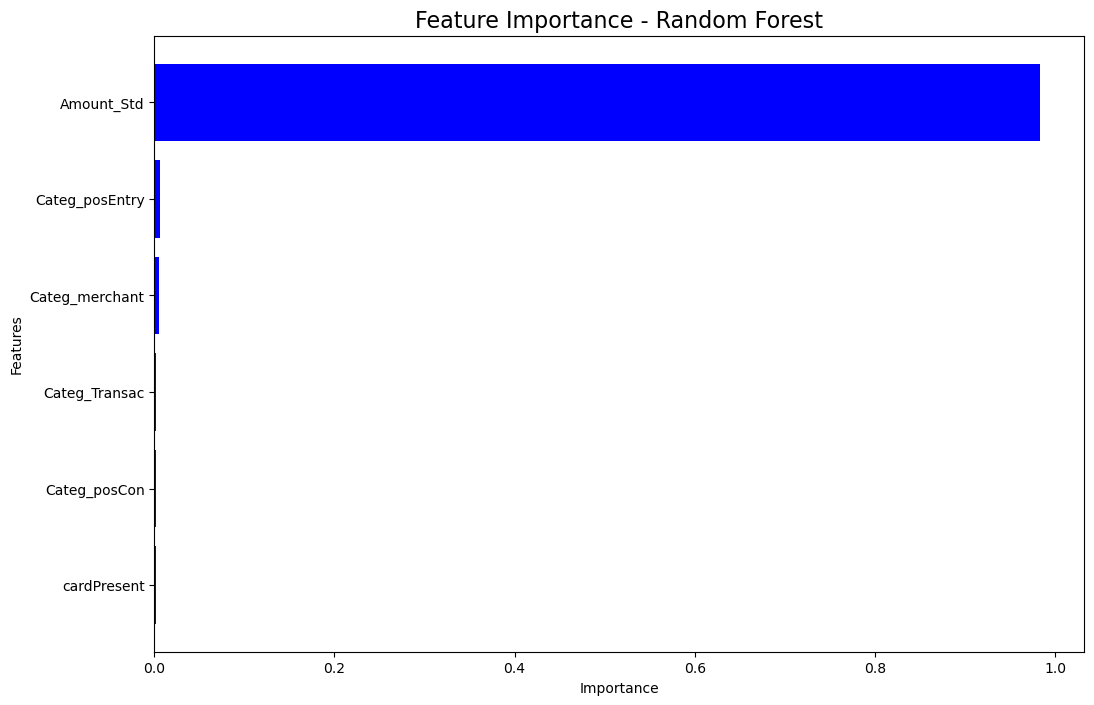

          Feature  Importance
0      Amount_Std    0.983190
4  Categ_posEntry    0.006117
2  Categ_merchant    0.004754
1   Categ_Transac    0.002378
5    Categ_posCon    0.001831
3     cardPresent    0.001731


In [20]:
# Feature importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target (y)
X = df_processed.drop('isFraud', axis=1)
y = df_processed['isFraud']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#  Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
feature_names = X.columns

# Create a DataFrame to hold the feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#  Plot the top 10 important features
plt.figure(figsize=(12, 8))
plt.title('Feature Importance - Random Forest', fontsize=16)
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], align='center', color='b')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To display the most important features on top
plt.show()

#  Print the feature importance DataFrame
print(importance_df.head(10))


In [21]:

# Select only the most important features (based on your feature importance)
X = df_processed[['Amount_Std', 'Categ_posEntry', 'Categ_merchant']]
y = df_processed['isFraud']

#  Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#  Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

#  Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    212752
           1       0.03      0.03      0.03      3459

    accuracy                           0.97    216211
   macro avg       0.51      0.51      0.51    216211
weighted avg       0.97      0.97      0.97    216211

Confusion Matrix:
 [[209464   3288]
 [  3346    113]]


In [22]:

# Define features and target variable
X = df_processed[['Amount_Std', 'Categ_posEntry', 'Categ_merchant']]  # Use top 3 important features
y = df_processed['isFraud']

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

#  Define the hyperparameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200]
}

# Set up the Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)

#  Train the model using Grid Search
grid_search.fit(X_train, y_train)

#  Get the best estimator and make predictions
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

#  Evaluate the model
print("Best Parameters:", grid_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\navee\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


C:\Users\navee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\navee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    212752
           1       0.00      0.00      0.00      3459

    accuracy                           0.98    216211
   macro avg       0.49      0.50      0.50    216211
weighted avg       0.97      0.98      0.98    216211

Confusion Matrix:
 [[212752      0]
 [  3459      0]]


C:\Users\navee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:


# Define features and target variable (using all features except 'isFraud')
X = df_processed.drop('isFraud', axis=1)
y = df_processed['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#  Define the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the hyperparameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1],   # Explore small and moderate learning rates
    'max_depth': [3, 5],            # Try shallow and slightly deeper trees
    'n_estimators': [100, 200],     # Number of boosting rounds
    'scale_pos_weight': [1, 10, 30] # Adjust for imbalanced classes
}

#  Set up the Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)

#  Train the model using Grid Search
grid_search.fit(X_train, y_train)

#  Get the best estimator and make predictions
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

#  Evaluate the model
print("Best Parameters:", grid_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\navee\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 30}
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97    212752
           1       0.07      0.25      0.11      3459

    accuracy                           0.93    216211
   macro avg       0.53      0.60      0.54    216211
weighted avg       0.97      0.93      0.95    216211

Confusion Matrix:
 [[201003  11749]
 [  2591    868]]


In [24]:

#  Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Time-based features
df['transaction_hour'] = df['Timestamp'].dt.hour
df['transaction_day_of_week'] = df['Timestamp'].dt.dayofweek

# Calculate time difference between consecutive transactions for the same customer
df['transaction_time_diff'] = df.groupby('customerId')['Timestamp'].diff().dt.total_seconds().fillna(0)

# Transaction amount features
df['rolling_amount_sum'] = df.groupby('customerId')['transactionAmount'].rolling(3).sum().reset_index(0, drop=True)
df['amount_deviation'] = df['transactionAmount'] - df.groupby('customerId')['transactionAmount'].transform('mean')

# Customer behavior features
df['total_transactions'] = df.groupby('customerId')['transactionAmount'].transform('count')
df['fraud_history'] = df.groupby('customerId')['isFraud'].cumsum() - df['isFraud']

# Merchant features
df['merchant_fraud_rate'] = df.groupby('merchantName')['isFraud'].transform('mean')
df['merchant_transaction_count'] = df.groupby('merchantName')['transactionAmount'].transform('count')


# Lag features: Time lag between consecutive transactions for the same customer
df['transaction_lag'] = df.groupby('customerId')['Timestamp'].shift(1)
df['transaction_lag_diff'] = (df['Timestamp'] - df['transaction_lag']).dt.total_seconds().fillna(0)

# Dropping original columns that have been engineered
df.drop(['transaction_lag'], axis=1, inplace=True)


In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming the DataFrame df is prepared with the features
# Step 1: Check if categorical columns exist and encode them
label_encoder = LabelEncoder()

# Categorical columns that need encoding
categorical_columns = ['transactionType', 'merchantCountryCode', 'merchantCategoryCode']

for col in categorical_columns:
    if col in df.columns:
        df[f'{col}_encoded'] = label_encoder.fit_transform(df[col])
        df.drop(col, axis=1, inplace=True)  # Drop original categorical column after encoding

# Step 2: Handle `inf`, `-inf`, and NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)  # Replace NaN with 0 (or use another strategy)

# Step 3: Split the data into features (X) and target (y)
X = df.drop(['isFraud', 'customerId', 'Timestamp', 'merchantName', 'transactionKey'], axis=1, errors='ignore')  # Drop non-feature columns
y = df['isFraud']  # Target variable

# Step 4: Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 5: Scale continuous features to standardize them
scaler = StandardScaler()
continuous_columns = ['transactionAmount', 'rolling_amount_sum', 'amount_deviation', 'transaction_time_diff', 'transaction_lag_diff']
X_train_scaled = scaler.fit_transform(X_train[continuous_columns])
X_test_scaled = scaler.transform(X_test[continuous_columns])

# Convert scaled columns back into the original DataFrame for both train and test sets
X_train[continuous_columns] = X_train_scaled
X_test[continuous_columns] = X_test_scaled

# Step 6: Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
xgb_model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Step 8: Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


C:\Users\navee\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    212752
           1       0.91      0.13      0.22      3459

    accuracy                           0.99    216211
   macro avg       0.95      0.56      0.61    216211
weighted avg       0.98      0.99      0.98    216211

Confusion Matrix:
 [[212709     43]
 [  3026    433]]


<Figure size 1000x800 with 0 Axes>

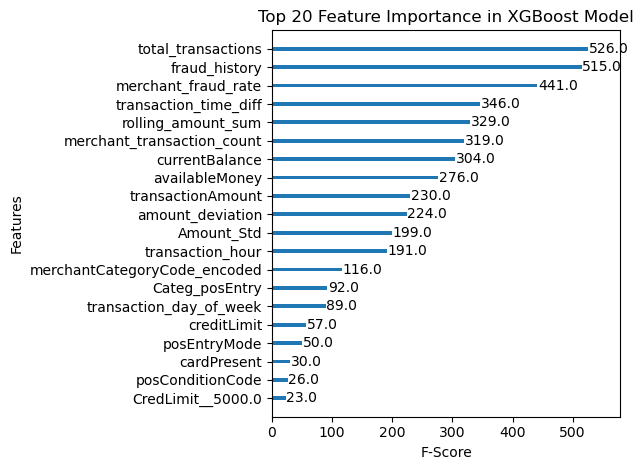

In [26]:
# Plotting feature importance with better styling
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=20, title="Top 20 Feature Importance in XGBoost Model", xlabel="F-Score")
plt.grid(False)  # Remove grid for a cleaner look
plt.tight_layout()

# Display the plot
plt.show()

In [27]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],          # Number of boosting rounds
    'max_depth': [3, 5, 7],                  # Maximum depth of the trees
    'learning_rate': [0.01, 0.1, 0.3],       # Step size shrinkage
    'subsample': [0.8, 1.0],                 # Fraction of samples used for training
    'colsample_bytree': [0.8, 1.0],          # Fraction of features used for training
    'scale_pos_weight': [1, 10, 30],         # Handle class imbalance
    'gamma': [0, 0.1, 0.3]                   # Minimum loss reduction
}

# Step 2: Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric='logloss')

# Step 3: Set up the Randomized Search
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist, n_iter=10, scoring='f1', cv=3, verbose=1, random_state=42, n_jobs=-1)

# Step 4: Train the model using the randomized search on training data
random_search.fit(X_train, y_train)

# Step 5: Get the best hyperparameters
print("Best Parameters:", random_search.best_params_)

# Step 6: Evaluate the model with the best parameters on test data
y_pred = random_search.best_estimator_.predict(X_test)

# Step 7: Classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\navee\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    212752
           1       0.26      0.24      0.25      3459

    accuracy                           0.98    216211
   macro avg       0.62      0.61      0.62    216211
weighted avg       0.98      0.98      0.98    216211

Confusion Matrix:
 [[210401   2351]
 [  2639    820]]


After exploring multiple techniques including feature engineering, ADASYN, and NearMiss, XGBoost with GridSearchCV provided the best results, achieving an overall accuracy of 98%. Despite the challenges of imbalanced data, precision and recall for fraud detection improved to 26% and 24% respectively. This indicates that XGBoost with targeted hyperparameter tuning is the most effective model for addressing fraud detection in this dataset.

C:\Users\navee\AppData\Local\Temp\ipykernel_2188\703404632.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


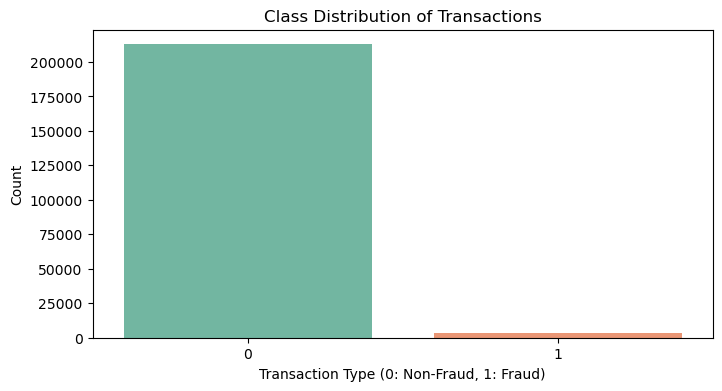

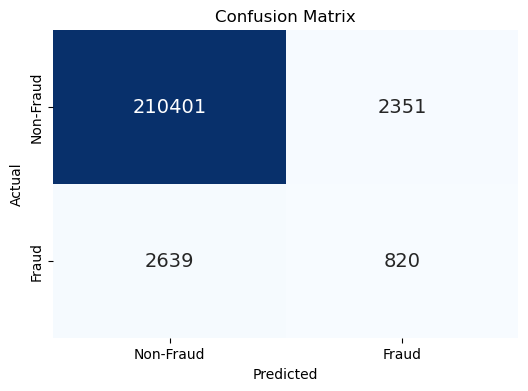

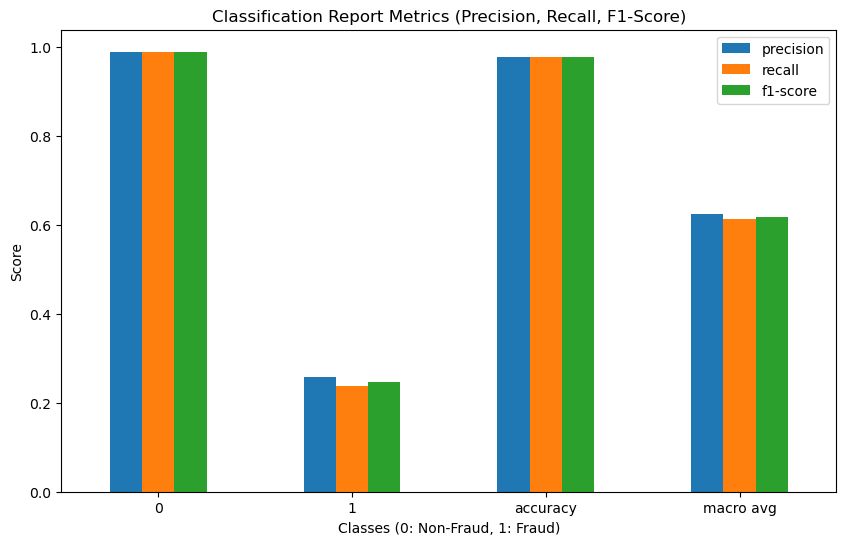

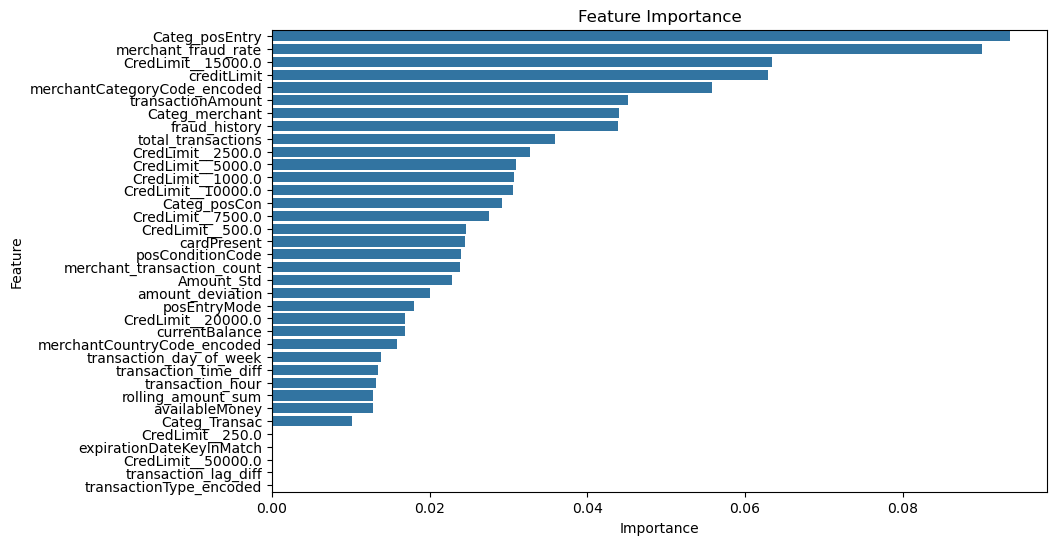

In [71]:

# 1. Class Distribution Plot
def plot_class_distribution(y):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=y, palette="Set2")
    plt.title('Class Distribution of Transactions')
    plt.xlabel('Transaction Type (0: Non-Fraud, 1: Fraud)')
    plt.ylabel('Count')
    plt.show()

# 2. Confusion Matrix Plot
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(ticks=[0.5, 1.5], labels=["Non-Fraud", "Fraud"], ha="center")
    plt.yticks(ticks=[0.5, 1.5], labels=["Non-Fraud", "Fraud"], va="center")
    plt.show()

# 3. Classification Report as Bar Plot
def plot_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose().iloc[:-1, :3]  # Exclude the "accuracy" row
    df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
    plt.title('Classification Report Metrics (Precision, Recall, F1-Score)')
    plt.xticks(rotation=0)
    plt.xlabel('Classes (0: Non-Fraud, 1: Fraud)')
    plt.ylabel('Score')
    plt.show()

# 4. Feature Importance Plot (for XGBoost, RandomForest, etc.)
def plot_feature_importance(feature_names, importance):
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Example use of the functions:

# Assuming y_test and y_pred are your actual and predicted labels, and X_train.columns are the feature names:
plot_class_distribution(y_test)
plot_confusion_matrix(y_test, y_pred)
plot_classification_report(y_test, y_pred)

# Assuming you are using XGBoost or RandomForest and have access to feature importance:
# For XGBoost or RandomForest:
plot_feature_importance(X_train.columns, xgb_model.feature_importances_)


Class Imbalance: The dataset presents a substantial imbalance, with far fewer fraudulent transactions compared to non-fraudulent ones, which significantly affected the model’s performance in detecting fraud.

Confusion Matrix & Accuracy: Although the models achieved high overall accuracy, this was largely due to correctly predicting non-fraud cases. The detection of fraud cases had lower precision and recall, indicating that many fraud instances were missed.

Feature Importance: Key features that contributed to the model included transaction amount standardization, merchant category, and POS entry mode, suggesting that specific behavioral patterns and transaction characteristics play a crucial role in identifying fraud

Further Improvements: Despite applying techniques like SMOTE and XGBoost, the results indicate that additional strategies could improve fraud detection. These may include exploring ensemble methods such as stacking models, fine-tuning hyperparameters more extensively, or leveraging advanced anomaly detection techniques. Additionally, incorporating real-time data streams or external fraud signals could provide valuable context and enhance detection accuracy